In [1]:
from importlib.metadata import version

pkgs = ['numpy', 'matplotlib', 'tiktoken', 'torch']
for p in pkgs:
    print(f"{p} version: {version(p)}")

!which python; python --version

numpy version: 2.1.2
matplotlib version: 3.9.2
tiktoken version: 0.9.0
torch version: 2.4.1
/mnt/lustre/work/macke/mwe102/.conda/sbi/bin/python
Python 3.10.15


In [2]:
import os
import math
import time, inspect
import urllib.request
from dataclasses import dataclass

import torch
import tiktoken
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

# Model definition

In [3]:
@dataclass
class GPTConfig:
    # config for gpt2 124M model
    block_size: int = 1024
    vocab_size: int = 50257 # later changed to 50304 during initialization
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768

# TODO
@dataclass
class TokenformerConfig:
    pass

In [4]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # note that these matrices also have a bias!
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd) # Wq, Wk, Wv matrices
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)     # Wo: final projection
        self.c_proj.NANOGPT_SCALE_INIT = 1.0  # a flag to identify this particular module
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # note: name is misleading, it is actually the causal mask, not bias!
        # this is the autoregressive mask
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.c_attn(x) # B, T, 3*d
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # these 4 lines can be replaced by flash attention
        # flash attention never materializes the TxT att matrix in GPU memory
        # relies on online softmax calculation
        """
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v
        """
        # replace by this line
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y


class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        # gaussian error linear unit, approximation by tanh is a historical quirk
        # unlike relu, gelu always contributes a local gradient in the tail end of the flat region
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x



class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        # prefer clean residual stream from outputs to all the way back to inputs
        # no normalization in the residual streams
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x



class GPT(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict( # the main container
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            # layers will be indexed by integers (0, 1, ...) instead of names (like wpe, wte)
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd), # final layer norm
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight tying scheme
        # wte weight redirected to the lm_head weight
        # wte weight original gets orphaned and hopefully cleaned up
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)
        
        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                # 2 times num layers as each layer adds 2 times to the residual path
                # once by attn layer and another time by the MLP layer
                std *= (2 * self.config.n_layer) ** (-0.5)
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias) # zero init bias is not pytorch default
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    

    def forward(self, idx, targets=None):
        # idx is of shape [B, T]
        B, T = idx.size()
        assert T <= self.config.block_size
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos) #    [T, n_embd]
        tok_emb = self.transformer.wte(idx) # [B, T, n_embd]
        x = tok_emb + pos_emb               # broadcasting hidden

        for block in self.transformer.h:
            x = block(x)
        
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.flatten(0, 1), targets.flatten())

        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t()) # inplace copying of a tensor
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k]) # inplace copying of a tensor

        return model

    def configure_optimizers(self, weight_decay, learning_rate, device):
        # just pick out params that require grad
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

        # create optim groups -- all 2d params will be weight decayed, biases and layernorms no decay
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]

        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and "cuda" in device
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        
        return optimizer

## Dataloader for the fineweb dataset (assuming shards are already available)

In [5]:
def load_tokens(filename: str):
    # expects .npy file
    npt = np.load(filename)
    ptt = torch.tensor(npt, dtype=torch.long)
    return ptt

class DataLoaderLite:

    def __init__(self, B, T, process_rank=0, num_processes=1, split='train'):
        self.B, self.T = B, T
        self.process_rank = process_rank
        self.num_processes = num_processes
        assert split in {'train', 'val'}

        # get the shard filename
        data_root = 'edu_fineweb10B'
        shards = os.listdir(data_root)
        shards = [s for s in shards if split in s]
        shards = sorted(shards)
        shards = [os.path.join(data_root, s) for s in shards]
        self.shards = shards
        assert len(shards) > 0, f"no shards found for split: {split}"
        master_process = process_rank == 0
        if master_process:
            print(f"found: {len(shards)} shards for: {split} split and num processes: {self.num_processes}")

        # state management
        self.reset()

    def reset(self):
        # useful in val_loader.reset()
        # state, initialize at shard 0 or first file
        self.current_shard = 0
        self.tokens = load_tokens(self.shards[self.current_shard])
        self.current_position = self.B * self.T * self.process_rank


    def next_batch(self):
        # prepare inputs and targets for a single *step* of the optimization
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]
        x = buf[:-1].view(B, T) # remove last token
        y = buf[1:].view(B, T)  # remove first token
        # advance to the next chunk of the array
        self.current_position += (B * T * self.num_processes)
        # check for next batch loading for all processes
        # if loading the next batch would be out of bounds, advance to next shard
        if self.current_position + (B*T*self.num_processes + 1) > len(self.tokens):
            self.current_shard = (self.current_shard + 1) % len(self.shards)
            self.tokens = load_tokens(self.shards[self.current_shard])
            self.current_position = B * T * self.process_rank
        return x, y

In [6]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.mps.is_available():
    device = "mps"
print(f"using device: {device}")
# device = "cpu" # OVERRIDE

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

using device: cuda


In [7]:
total_batch_size = 524_288 # 2**19, closest power of 2 to ~0.5M
B = 32   # micro batch size: how many rows we are processing in a single forward-backward step (32 fits in one A100 40GB, was 16 earlier)
T = 1024 # sequence length
assert total_batch_size % (B * T) == 0, "total batch size in number of tokens should be divisible by B*T"
grad_accum_steps = total_batch_size // (B * T)
print(f"total desired batch size: {total_batch_size} tokens")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

# initialize the dataloader
train_loader = DataLoaderLite(B=B, T=T, split='train')
val_loader = DataLoaderLite(B=B, T=T, split='val')

# initialize tokenizer for sampling through the model
enc = tiktoken.get_encoding("gpt2")

total desired batch size: 524288 tokens
=> calculated gradient accumulation steps: 16
found: 99 shards for: train split and num processes: 1
found: 1 shards for: val split and num processes: 1


In [8]:
# enable tf32, now matmuls will use tf32 (tensor cores from A100)
torch.set_float32_matmul_precision('high') # default is highest

In [9]:
max_lr = 6e-4 # prev constant lr that we were using
min_lr = max_lr * 0.1
warmup_steps = 100
max_steps=151

In [10]:
def get_lr(it):
    # linear warmup
    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps
    # if it > lr decay iters, return min_lr
    if it > max_steps:
        return min_lr
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # starts at 1, goes to 0
    return min_lr + coeff * (max_lr - min_lr)

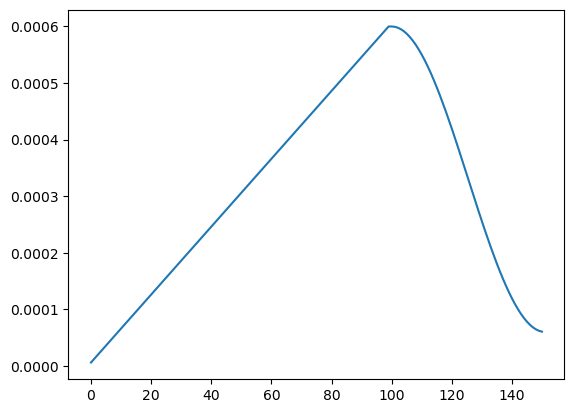

In [11]:
steps = np.arange(max_steps)
lrs = np.array([get_lr(it) for it in steps])

plt.plot(steps, lrs); plt.show()

In [12]:
# len(optimizer.param_groups)
def generate_and_print_samples(model, tokenizer, device,
                               num_return_sequences = 4,
                               max_length = 32,
                               start_context = "Hello, I'm a language model,",
                               ):
    
    model.eval()
    
    tokens = tokenizer.encode(start_context)
    tokens = torch.tensor(tokens, dtype=torch.long)
    tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
    xgen = tokens.to(device)
    # don't interfere with other seeds
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(42)

    while xgen.size(1) < max_length:
        # forward the model to get the logits
        with torch.no_grad():
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits, loss = model(xgen) # (B, T, vocab_size)
            # take the logits at the last position
            logits = logits[:, -1, :] # (B, vocab_size)
            # get the probabilities
            probs = F.softmax(logits, dim=-1)
            # do top-k sampling of 50 (huggingface pipeline default)
            # topk_probs here becomes (5, 50), topk_indices is (5, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            # select a token from the top-k probabilities
            # note: multinomial does not demand the input to sum to 1
            ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
            # gather the corresponding indices
            xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
            # append to the sequence
            xgen = torch.cat((xgen, xcol), dim=1)
    # print the generated text
    for i in range(num_return_sequences):
        tokens = xgen[i, :max_length].tolist()
        decoded = tokenizer.decode(tokens)
        print(f"sample {i}: {decoded}")
    
    model.train()


def calc_loss_loader(data_loader, model, device, num_batches, print_loss=True) -> float:
    model.eval()
    data_loader.reset()

    with torch.no_grad():
        loss_accum = 0.0
        loss_steps = num_batches
        for _ in range(loss_steps):
            x, y = data_loader.next_batch()
            x, y = x.to(device), y.to(device)
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits, loss = model(x, y)
            loss = loss / loss_steps
            loss_accum += loss.detach()
    
    if print_loss:
        # averaged per-step loss, averaged over `num_batches` batches or steps
        print(f"Validation loss: {loss_accum.item():.4f}")
    
    model.train()
    return loss_accum.item()

In [13]:
# model = GPT(GPTConfig())
model = GPT(GPTConfig(vocab_size=50304)) # 6th optimization
model.to(device)
use_compile = False # torch.compile interferes with HellaSwag eval and Generation. TODO fix
if use_compile:
    model = torch.compile(model) # 4th optimization

optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device) # fused update

max_steps = 1001
val_loss_steps = 20
for step in range(max_steps):

    # once in a while evaluate on the validation set
    if step % 50 == 0:
        _ = calc_loss_loader(val_loader, model, device, num_batches=val_loss_steps)

    # once in a while sample from the model
    if step % 50 == 0 and (not use_compile):
        generate_and_print_samples(model, enc, device)

    # start timer
    t0 = time.time()
    model.train()
    optimizer.zero_grad()
    loss_accum = 0.0

    # gradient-accumulation
    for micro_step in range(grad_accum_steps):
        # data loading
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
    
        # forward-backward and step
        # amp for 3rd optimization, just surround forward pass and loss calculation, only possible in A100
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward() # deposits gradients, i.e., += on nodes

    # clip gradient norms to 1.0, returns total norm of the gradient vector
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # determine lr for this step
    lr = get_lr(step)
    # pytorch syntax to set the learning rate for the parameters
    for param_group in optimizer.param_groups:
        # param_group is a dict
        param_group['lr'] = lr
    optimizer.step()

    # wait for gpu to finish the compute and measure time
    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0)*1000 # time difference for one-batch or step in miliseconds
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps
    tps = tokens_processed / (t1 - t0)
    
    print(f"Step {step:4d} | loss: {loss_accum.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt:.2f}ms | tok/sec: {tps:.2f}")


print(f"logits.shape: {logits.shape}, logits dtype: {logits.dtype}, loss.dtype: {loss.dtype}")

number of parameters: 123.69M
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
Validation loss: 10.9514
sample 0: Hello, I'm a language model,CHR 351ointmentprotantically surrounded flaw TCUorigin Effective surrounded senate rodents�oviribution Feinstein Homer tappedrica relentlessppedribution 351
sample 1: Hello, I'm a language model,iggs Socialism Yangointment rodents contributors investigatesteness emulator toughestClientTesla "[ricaSTE TI TI Places TFencersRRArray Privacy undone
sample 2: Hello, I'm a language model, glimpserint236udzee unve Neighvanceces arise Account Student Privacy Privacy beloved Christina Patterns sugg Sche continental iCloudflo 2012Listener
sample 3: Hello, I'm a language model, unvewarts evoke investigates investigateswsws Magnetmens Art altercationperformanceribution roast368 senate Actinguls breastignmentmissing facesmare supremacists
Step    0 | loss: 10.9

### next todos:
- init tokenformer
- check tokenformer's validation losses for each size compared to gpt2
- start `build-tokenformer-fineweb` notebook

### 1. example snapshot
```
number of parameters: 123.69M
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
Validation loss: 10.9597
Step    0 | loss: 10.958449 | lr: 6.0000e-06 | norm: 15.6885 | dt: 40388.14ms | tok/sec: 12981.24
Step    1 | loss: 10.628062 | lr: 1.2000e-05 | norm: 12.3712 | dt: 3312.92ms | tok/sec: 158255.62
Step    2 | loss: 10.245197 | lr: 1.8000e-05 | norm: 7.8265 | dt: 3318.94ms | tok/sec: 157968.57

...

Step   49 | loss: 7.107584 | lr: 3.0000e-04 | norm: 0.7933 | dt: 3401.66ms | tok/sec: 154127.19
Validation loss: 7.1122
Step   50 | loss: 7.174483 | lr: 3.0600e-04 | norm: 1.1656 | dt: 3402.44ms | tok/sec: 154091.90

...

Step   97 | loss: 6.434902 | lr: 5.8800e-04 | norm: 0.6139 | dt: 3407.81ms | tok/sec: 153849.04
Step   98 | loss: 6.499994 | lr: 5.9400e-04 | norm: 0.8524 | dt: 3409.96ms | tok/sec: 153752.11
Step   99 | loss: 6.449703 | lr: 6.0000e-04 | norm: 0.6719 | dt: 3403.89ms | tok/sec: 154026.12
Validation loss: 6.4133
Step  100 | loss: 6.484104 | lr: 6.0000e-04 | norm: 0.8199 | dt: 3409.96ms | tok/sec: 153752.01
logits.shape: torch.Size([32, 1024, 50304]), logits dtype: torch.bfloat16, loss.dtype: torch.float32

```

### 2. without `torch.compile` and with sample generation
```
number of parameters: 123.69M
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
Validation loss: 10.9514
sample 0: Hello, I'm a language model,CHR 351ointmentprotantically surrounded flaw TCUorigin Effective surrounded senate rodents�oviribution Feinstein Homer tappedrica relentlessppedribution 351
sample 1: Hello, I'm a language model,iggs Socialism Yangointment rodents contributors investigatesteness emulator toughestClientTesla "[ricaSTE TI TI Places TFencersRRArray Privacy undone
sample 2: Hello, I'm a language model, glimpserint236udzee unve Neighvanceces arise Account Student Privacy Privacy beloved Christina Patterns sugg Sche continental iCloudflo 2012Listener
sample 3: Hello, I'm a language model, unvewarts evoke investigates investigateswsws Magnetmens Art altercationperformanceribution roast368 senate Actinguls breastignmentmissing facesmare supremacists
Step    0 | loss: 10.955029 | lr: 6.0000e-06 | norm: 15.3463 | dt: 4813.04ms | tok/sec: 108930.64
Step    1 | loss: 10.631693 | lr: 1.2000e-05 | norm: 11.6429 | dt: 3883.76ms | tok/sec: 134995.12
Step    2 | loss: 10.274923 | lr: 1.8000e-05 | norm: 7.6928 | dt: 4039.76ms | tok/sec: 129781.83

...

Step   48 | loss: 7.203589 | lr: 2.9400e-04 | norm: 1.5565 | dt: 4001.99ms | tok/sec: 131006.80
Step   49 | loss: 7.104921 | lr: 3.0000e-04 | norm: 0.9878 | dt: 4004.38ms | tok/sec: 130928.52
Validation loss: 7.1181
sample 0: Hello, I'm a language model,000, we by a first in these new used of the the it at that the.
There in your the.
sample 1: Hello, I'm a language model, so by the body.
The future.” of a an make that it, he the small of the and
sample 2: Hello, I'm a language model, and the year of the new by any the “- A the same the other for the the own the first with
sample 3: Hello, I'm a language model, they do the world.
The small to they you the work on the most is not them to not the two all
Step   50 | loss: 7.178192 | lr: 3.0600e-04 | norm: 1.5985 | dt: 3992.52ms | tok/sec: 131317.66

...

Step   99 | loss: 6.446934 | lr: 6.0000e-04 | norm: 0.5210 | dt: 4014.07ms | tok/sec: 130612.47
Validation loss: 6.4060
sample 0: Hello, I'm a language model, if you
As a great
In those it?
This, an the
The work?
the
I
sample 1: Hello, I'm a language model, then just all that he was not know that the year” (H” (A, she had in the
sample 2: Hello, I'm a language model, the first very been taken at the area of children than the
-time, or three-based, the same was
sample 3: Hello, I'm a language model, they was a very a long-a is going to the end it has the "a-ces. It

Step  100 | loss: 6.474727 | lr: 6.0000e-04 | norm: 0.5555 | dt: 4012.42ms | tok/sec: 130666.34
Step  101 | loss: 6.422134 | lr: 5.9949e-04 | norm: 0.8457 | dt: 4013.04ms | tok/sec: 130645.99

...

Step  149 | loss: 6.160313 | lr: 6.2046e-05 | norm: 0.1937 | dt: 4005.23ms | tok/sec: 130900.94
Validation loss: 6.1286
sample 0: Hello, I'm a language model, when the one of a way is also used after the book of our mother of the way to that it will be in
sample 1: Hello, I'm a language model, there also an important for a good one of this particular-p) would do you are much of our family. You
sample 2: Hello, I'm a language model, and the need, because in the idea of any process of these things to the need to be a certain of a sense
sample 3: Hello, I'm a language model, it comes to be a person, they can try to you use our home and is your brain, as you are that
Step  150 | loss: 6.167456 | lr: 6.0512e-05 | norm: 0.1955 | dt: 3995.44ms | tok/sec: 131221.58
logits.shape: torch.Size([32, 1024, 50304]), logits dtype: torch.bfloat16, loss.dtype: torch.float32

```

In [14]:
!nvidia-smi

Mon Apr  7 11:32:50 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   41C    P0              70W / 250W |  39747MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [16]:
del model
del logits
del x, y

with torch.no_grad():
    torch.cuda.empty_cache()

In [17]:
del optimizer

In [18]:
torch.cuda.is_bf16_supported()

True

In [19]:
!nvidia-smi

Mon Apr  7 13:57:09 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   41C    P0              70W / 250W |  17591MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--